Changelog:  (Last Updated 2025-02-26)

# Probabilistic ML: Assignment 3
- **Deadline**: 2025-03-16 (March 16th 2025, 23:59)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.

- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ba35dd6e60e7613b22eb9b337c14c69430836c6889a857c06122a3bb3d716a8c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.

    epsilon = torch.randn(num_samples, mean.shape[-1])
    return mean + torch.exp(log_std) * epsilon

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples

    samples = diag_gaussian_samples(mean, log_std, num_samples)
    log_q = diag_gaussian_logpdf(samples, mean, log_std)
    elbo = torch.mean(logprob(samples) - log_q)
    return elbo



**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 20 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
  return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  return -batch_elbo(log_posterior_A_beat_B_20_times_1_arg, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  0%|          | 1/1200 [00:00<02:10,  9.18it/s]

Iteration 0 lower bound 18.287601470947266


  4%|▎         | 42/1200 [00:00<00:10, 113.68it/s]

Iteration 25 lower bound 15.793889999389648


  6%|▌         | 66/1200 [00:00<00:11, 95.19it/s]

Iteration 50 lower bound 12.486295700073242


  7%|▋         | 87/1200 [00:00<00:13, 85.26it/s]

Iteration 75 lower bound 8.76154613494873


 10%|▉         | 114/1200 [00:01<00:10, 106.54it/s]

Iteration 100 lower bound 6.615384578704834
Iteration 125 lower bound 5.8235321044921875


 13%|█▎        | 161/1200 [00:01<00:10, 97.79it/s] 

Iteration 150 lower bound 5.9664225578308105


 16%|█▌        | 186/1200 [00:01<00:09, 102.24it/s]

Iteration 175 lower bound 5.155362129211426


 18%|█▊        | 221/1200 [00:02<00:09, 98.38it/s]

Iteration 200 lower bound 4.728875637054443


 20%|██        | 243/1200 [00:02<00:10, 94.94it/s]

Iteration 225 lower bound 4.6094865798950195


 23%|██▎       | 280/1200 [00:02<00:07, 128.85it/s]

Iteration 250 lower bound 4.6202006340026855
Iteration 275 lower bound 4.480128765106201


 28%|██▊       | 331/1200 [00:03<00:05, 155.84it/s]

Iteration 300 lower bound 4.168866157531738
Iteration 325 lower bound 3.8727924823760986


 32%|███▏      | 384/1200 [00:03<00:03, 210.33it/s]

Iteration 350 lower bound 4.14475154876709
Iteration 375 lower bound 4.143530368804932
Iteration 400 lower bound 4.099917411804199


 37%|███▋      | 440/1200 [00:03<00:03, 198.62it/s]

Iteration 425 lower bound 3.9532623291015625
Iteration 450 lower bound 3.9741370677948


 40%|████      | 480/1200 [00:03<00:04, 152.59it/s]

Iteration 475 lower bound 4.029905796051025


 43%|████▎     | 511/1200 [00:04<00:05, 115.83it/s]

Iteration 500 lower bound 3.860996723175049


 46%|████▌     | 554/1200 [00:04<00:05, 124.21it/s]

Iteration 525 lower bound 3.920161485671997
Iteration 550 lower bound 4.0467963218688965


 50%|█████     | 600/1200 [00:04<00:04, 140.43it/s]

Iteration 575 lower bound 3.9356369972229004
Iteration 600 lower bound 4.04716157913208


 54%|█████▍    | 648/1200 [00:05<00:04, 114.28it/s]

Iteration 625 lower bound 4.085026741027832
Iteration 650 lower bound 3.9361844062805176


 57%|█████▋    | 686/1200 [00:05<00:05, 95.62it/s]

Iteration 675 lower bound 3.8456625938415527


 60%|█████▉    | 714/1200 [00:06<00:04, 106.93it/s]

Iteration 700 lower bound 3.976198196411133


 61%|██████▏   | 736/1200 [00:06<00:05, 80.56it/s]

Iteration 725 lower bound 3.9279322624206543


 64%|██████▍   | 765/1200 [00:06<00:05, 73.15it/s]

Iteration 750 lower bound 3.946366786956787


 68%|██████▊   | 821/1200 [00:07<00:02, 160.11it/s]

Iteration 775 lower bound 3.8824915885925293
Iteration 800 lower bound 3.9271209239959717
Iteration 825 lower bound 3.858717441558838


 75%|███████▍  | 896/1200 [00:07<00:01, 256.80it/s]

Iteration 850 lower bound 3.8502345085144043
Iteration 875 lower bound 3.9069533348083496
Iteration 900 lower bound 3.905402660369873


 80%|███████▉  | 954/1200 [00:07<00:01, 236.83it/s]

Iteration 925 lower bound 3.937187671661377
Iteration 950 lower bound 3.9657089710235596


 85%|████████▌ | 1023/1200 [00:07<00:00, 290.02it/s]

Iteration 975 lower bound 3.836557388305664
Iteration 1000 lower bound 3.929842472076416
Iteration 1025 lower bound 3.8997802734375


 91%|█████████ | 1089/1200 [00:07<00:00, 308.00it/s]

Iteration 1050 lower bound 3.965366840362549
Iteration 1075 lower bound 3.910419464111328
Iteration 1100 lower bound 3.9827892780303955


100%|█████████▉| 1195/1200 [00:08<00:00, 333.83it/s]

Iteration 1125 lower bound 3.870025157928467
Iteration 1150 lower bound 4.053452014923096
Iteration 1175 lower bound 4.0089826583862305


100%|██████████| 1200/1200 [00:08<00:00, 145.58it/s]
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 1200 lower bound 3.976722240447998


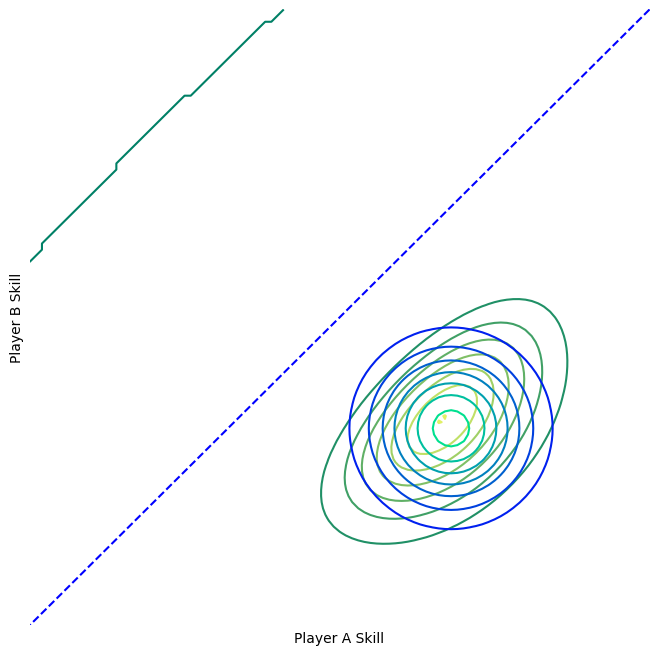

<Figure size 640x480 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std  = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
callback(params, n_iters)

def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 20 games and player B winning 20 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_20_times_1_arg, params[0], params[1], num_samples_per_iter)








   **e) [3pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 25%|██▌       | 25/100 [00:00<00:00, 244.19it/s]

Iteration 0 lower bound 57.219940185546875
Iteration 25 lower bound 50.75338363647461
Iteration 50 lower bound 41.06968688964844


100%|██████████| 100/100 [00:00<00:00, 283.98it/s]


Iteration 75 lower bound 34.942745208740234
Iteration 100 lower bound 33.10441970825195


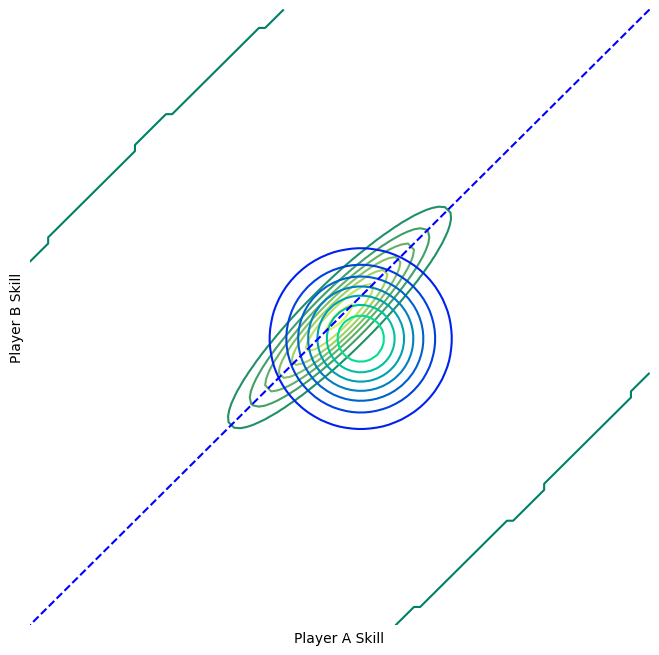

<Figure size 640x480 with 0 Axes>

In [ ]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
callback(params, n_iters)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)


The blue contours (approximate posterior) apprear to be more circular compared to the green contours (true posterior). The green contours' shape along the diagonal suggests there is a correlation between Plaer A and Player B's skills. This happens because the fully-factorized Gaussian assumes independence between Plaer A and Player B's skills.

Yes, it would make a better approximation in this instance, beacuse the non-factorized Gaussian could capture the correlations between variables, while the fully-factorized Gaussian cannot. Thus, the non-factorized Gaussian would produce a more accurate approximation when the true posterior has correlation between variables.

## 1.2 [34 pts] Approximate inference conditioned on real data

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [ ]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)


**c) [3pts]** Optimize, and report the final loss.

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

callback(params, n_iters)

Optimizing variational parameters...


  2%|▏         | 4/200 [00:00<00:05, 34.03it/s]

Iteration 0 lower bound 2235.029541015625


 17%|█▋        | 34/200 [00:00<00:04, 38.55it/s]

Iteration 25 lower bound 1698.2506103515625


 29%|██▉       | 58/200 [00:01<00:03, 44.55it/s]

Iteration 50 lower bound 1593.0977783203125


 42%|████▏     | 83/200 [00:02<00:03, 37.84it/s]

Iteration 75 lower bound 1551.9788818359375


 54%|█████▎    | 107/200 [00:02<00:02, 31.41it/s]

Iteration 100 lower bound 1537.57666015625


 64%|██████▍   | 129/200 [00:03<00:02, 30.88it/s]

Iteration 125 lower bound 1532.4801025390625


 78%|███████▊  | 155/200 [00:04<00:01, 33.70it/s]

Iteration 150 lower bound 1526.809326171875


 90%|█████████ | 181/200 [00:05<00:00, 35.36it/s]

Iteration 175 lower bound 1522.32470703125


100%|██████████| 200/200 [00:05<00:00, 36.43it/s]

Iteration 200 lower bound 1519.0693359375


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

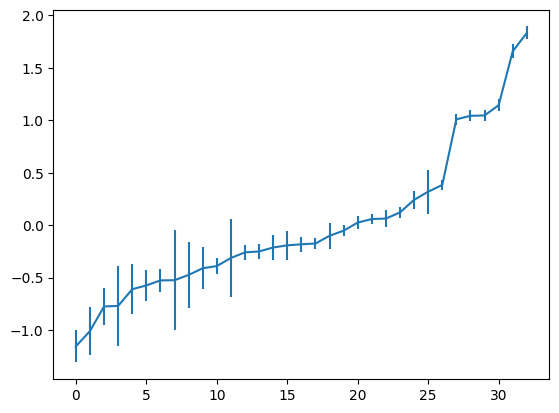

In [ ]:
mean_skills, logstd_skills = params[0].detach(), params[1].detach()  # Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors

variance_skills = torch.exp(2 * logstd_skills)
sorted_indices = torch.argsort(mean_skills)
mean_skills_sorted = mean_skills[sorted_indices]
variance_skills_sorted = variance_skills[sorted_indices]

plt.errorbar(range(num_players), mean_skills_sorted, variance_skills_sorted)



**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
for i in range(1,11):
    print(names[sorted_indices[-i]])

Manchester City
Liverpool
Manchester Utd
Tottenham
Arsenal
Chelsea
Leicester City
Brentford
Wolves
West Ham


**f) [3pt]** Plot samples from the joint posterior over the skills of Arsenal and Liverpool. Based on your samples, describe in a sentence the relationship between the skills of the teams. (Is one better than the other? Are they approximately even?)

Arsenal
Liverpool


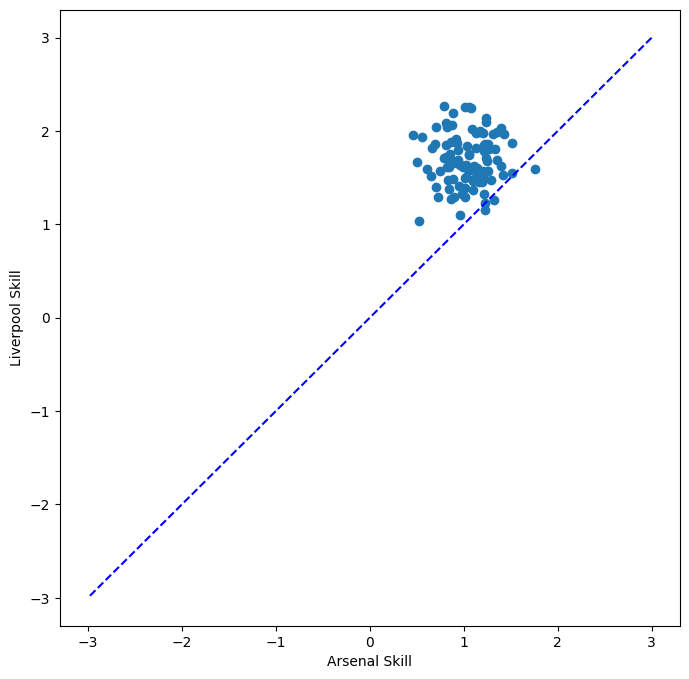

In [ ]:
arsenal_ix = 0
liverpool_ix = 15
print(names[arsenal_ix])
print(names[liverpool_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, arsenal_ix], samples[:, liverpool_ix])


Liverpool has a higher skill than Arsenal as the scatter plots are mainly centered above the blue line.

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Your answer here.

Suppose there are 2 players A and B. The skills of player A and B are $z_A$ and $z_B$.

Let $y_A=z_A-z_B, y_B=z_B$.

$p(z_A>z_B)=p(z_A-z_B>0)=p(y_A>0)$

Then $A=\begin{bmatrix}1 & -1\\0 & 1\end{bmatrix}$

As z is Gaussian, $z \sim N(\mu,\Sigma)$.

$y=\begin{bmatrix}y_A\\y_B\end{bmatrix}=\begin{bmatrix}z_A-z_B\\z_B\end{bmatrix}=\begin{bmatrix}1 & -1\\0 & 1\end{bmatrix}\begin{bmatrix}z_A\\z_B\end{bmatrix}=Az$

Then $y \sim N(A\mu, A\Sigma A^T)$.

$A\mu=\begin{bmatrix}1 & -1\\0 & 1\end{bmatrix}\begin{bmatrix}\mu_A\\\mu_B\end{bmatrix}=\begin{bmatrix}\mu_A-\mu_B\\\mu_B\end{bmatrix}$

$A\Sigma A^T=\begin{bmatrix}1 & -1\\0 & 1\end{bmatrix}\begin{bmatrix}{\sigma_1}^2 & 0\\0 & {\sigma_2}^2\end{bmatrix}\begin{bmatrix}1 & 0\\-1 & 1\end{bmatrix}=\begin{bmatrix}{\sigma_A}^2 & -{\sigma_B}^2\\0 & {\sigma_B}^2\end{bmatrix}\begin{bmatrix}1 & 0\\-1 & 1\end{bmatrix}=\begin{bmatrix}{\sigma_A}^2+{\sigma_B}^2 & -{\sigma_B}^2\\-{\sigma_B}^2 & {\sigma_B}^2\end{bmatrix}$

So, $y_A \sim N((A\mu)_1, (A\Sigma A^T)_{11})=N(\mu_A-\mu_B,{\sigma_A}^2+{\sigma_B}^2)$

Let $x=\frac{y_A-\mu_A+\mu_B}{\sqrt{{\sigma_A}^2+{\sigma_B}^2}}\sim N(0,1)$

$p(y_A>0)=1-p(y_A<0)=1-p(x<\frac{\mu_B-\mu_A}{\sqrt{{\sigma_A}^2+{\sigma_B}^2}})=1-\Phi(\frac{\mu_B-\mu_A}{\sqrt{{\sigma_A}^2+{\sigma_B}^2}})=\Phi(\frac{\mu_A-\mu_B}{\sqrt{{\sigma_A}^2+{\sigma_B}^2}}),$ where $\Phi$ is the cdf of standard normal distribution.





**h) [4pts]** Compute the probability under your approximate posterior that Arsenal has higher skill than Liverpool. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_skilled_than_B(N, A_ix, B_ix):
  mean_A = mean_skills[A_ix]
  mean_B = mean_skills[B_ix]
  std_A = torch.exp(logstd_skills[A_ix])
  std_B = torch.exp(logstd_skills[B_ix])
  formula_est = Normal(0,1).cdf((mean_A-mean_B)/torch.sqrt(std_A**2+std_B**2))

  samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
  mc_est = torch.sum(samples[:, A_ix] > samples[:, B_ix]) / samples.shape[0]
  return formula_est, mc_est

formula_est, mc_est = prob_A_skilled_than_B(10000, arsenal_ix, liverpool_ix)
print(f"The probability using the formula derived:{formula_est}")
print(f"The probability using Monte Carlo:{mc_est}")



The probability using the formula derived:0.037441104650497437
The probability using Monte Carlo:0.03519999980926514


**i) [2pts]** Compute the probability that Arsenal is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_lowest_ix = torch.argsort(mean_skills)[4]
formula_est, mc_est = prob_A_skilled_than_B(10000, arsenal_ix, fifth_lowest_ix)
print(f"The probability using the formula derived:{formula_est}")
print(f"The probability using Monte Carlo:{mc_est}")


The probability using the formula derived:0.9988954663276672
The probability using Monte Carlo:0.9994999766349792


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(5, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

Your answer here.

No, it won't change the answer of either of the previous 2 questions in expectation.

Because $p(z_A>z_B)$ only depends on $\mu_A-\mu_B$ and $\sigma_A^2+\sigma_B^2$. $\mu_A-\mu_B$ which is the relative difference, remains unchanged. Because all the players have the same prior shift from N(0, 1) to N(5, 1), whicb means each player's prior mean is shifted by 5, $\mu_A-\mu_B$ will not change. However, the absolute skill levels of the piror for each player will change.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

Markov chain Monte Carlo (MCMC) method is a better overall approximation to the true posterior over all skills conditioned on all games compared to Stochastic Variational Inference (SVI) based on the plots in 1.1c) and 1.1e) which SVI didn't capture the behavior of player's true skill pattern well.

Because MCMC accounts for uncertainty and SVI is restricted to variational assumptions. For example, SVI's diagonal covariance fails to capture the dependency between the skills of two palyers.